# Computer Vision Coursework Submission (INM460)

**Student name, ID and cohort:** Yumi Heo (230003122) - PG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Models', 'CW_Dataset', 'Code', 'Video', 'test_functions.ipynb']


### Load packages

In the next cell you should load all the packages required to test your functions.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from joblib import dump, load
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
from skimage.transform import resize
from skimage import io, color, img_as_ubyte
from skimage.io import imread
from sklearn.cluster import KMeans
from sklearn import metrics
from skimage.feature import hog
from matplotlib import rc
import matplotlib.animation as animation

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` and `MaskDetectionVideo` to avoid having to reload them each time.

In [ ]:
# Load SVMs and MLP models
final_sift_svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','re_sift_svm_model.joblib'))
final_hog_svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','hogsvm_model.joblib'))
final_hog_mlp = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','hogmlp_model.joblibb'))

In [ ]:
# Load the trained ResNet
final_resnet_path = '/content/drive/MyDrive/CW_Folder_PG/Models/pretrained_resnet32_model.pth'
final_resnet_dict = torch.load(final_resnet_path, map_location=torch.device('cpu'))

# Define the architecture of the model
num_classes = 3

# Reconstruct the model structure
resnet = models.resnet34(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Load the saved state dictionary into the model
resnet.load_state_dict(final_resnet_dict)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

**From here, most of the codes below is derived from the coursework code file**

### Define the MaskDetection function

In [ ]:
# Define functions for the MaskDetection function

# The function for loading the test set
def load_images_labels(image_dir, label_dir):
    images = []
    labels = []

    image_files = sorted(os.listdir(image_dir))

    for image_file in image_files:
        if image_file.endswith('.jpeg'):
            image_path = os.path.join(image_dir, image_file)
            image = io.imread(image_path)
            images.append(image)

            label_file = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
            if os.path.exists(label_file):
                with open(label_file, 'r') as f:
                    label = f.read().strip()
                    labels.append(label)

    return images, labels

# Define the device
device = torch.device("cpu")

# Define the test transform
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #
])

# Define a class for the dataset
class CNN_dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y

# Evaluate the resnet model on the test set
def evaluate_model(model, dataset, device):
    model.eval()
    correct = 0
    total = len(dataset)
    predictions = []

    with torch.no_grad():
        for i in range(len(dataset)):
            image, label = dataset[i]
            image = image.unsqueeze(0).to(device)
            output = model(image)
            _, predicted = torch.max(output.data, 1)
            predictions.append(predicted.item())
            if predicted == label:
                correct += 1

    accuracy = 100 * correct / total
    return accuracy, predictions

# Define the MaskDetection function
def MaskDetection(path_to_testset, model_type):
    image_dir = os.path.join(path_to_testset, 'images')
    label_dir = os.path.join(path_to_testset, 'labels')
    X_test, y_test = load_images_labels(image_dir, label_dir)
    y_test = [float(item) for item in y_test]

    # Mapping labels to strings
    label_mapping = {0: 'no mask', 1: 'mask', 2: 'incorrect mask'}

    # This SIFT is for a SVM model
    sift = cv2.SIFT_create()

    # Define the resizing size
    target_size = (256, 256)

    # List to store resized images
    resized_X_test_siftsvm = []

    # Resize images in the test set
    for image in X_test:
        resized_image = resize(image, target_size, anti_aliasing=True)
        resized_X_test_siftsvm.append(resized_image)

    # Feature extraction using SIFT
    test_hist_list = []
    des_list = []

    for i in range(len(resized_X_test_siftsvm)):
        img = img_as_ubyte(color.rgb2gray(X_test[i]))
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            des_list.append(des)
            des_array = np.vstack(des_list)

        k = len(np.unique(y_test)) * 10

        if len(des_array) < k:
            test_hist_list.append(None)
            continue
        # Using K-means clustering
        kmeans = KMeans(n_clusters=k, n_init='auto').fit(des_array)

        if des is not None:
            hist = np.zeros(k)

            idx = kmeans.predict(des)

            for j in idx:
                hist[j] = hist[j] + (1 / len(des))

            test_hist_list.append(hist)

        else:
            test_hist_list.append(None)

    # Remove potential cases of images with no descriptors
    idx_not_empty = [i for i, x in enumerate(test_hist_list) if x is not None]
    test_hist_list = [test_hist_list[i] for i in idx_not_empty]
    y_test_not_empty = [y_test[i] for i in idx_not_empty]
    test_hist_array = np.vstack(test_hist_list)

    # Set up an if loop to select the right model type
    if model_type == 'siftsvm':
        final_model = final_sift_svm
        sift_svm_y_test_pred = final_model.predict(test_hist_array).tolist()

        # Select 4 random images
        random_img = random.sample(range(len(resized_X_test_siftsvm)), 4)

        # Plot the random images
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        for i, idx in enumerate(random_img):
            image, label = X_test[idx], label_mapping[int(y_test[idx])]
            ax = axes[i]
            ax.imshow(image)
            ax.set_title(f'Label: {label}, prediction: {label_mapping[sift_svm_y_test_pred[idx]]}')
            ax.set_axis_off()

        plt.show()
    # For HOP+SVM and HOG+MLP models
    elif model_type == 'hogsvm' or model_type == 'hogmlp':
        # Define HOG parameters
        orientations = 8
        pixels_per_cell = (16, 16)
        cells_per_block = (1, 1)

        # List to store resized images
        resized_X_test_hog = []

        # Resize images in the test set
        for image in X_test:
            resized_image = resize(image, target_size, anti_aliasing=True)
            resized_X_test_hog.append(resized_image)

        # Extract HOG features
        hog_features_test_list = []
        for img in resized_X_test_hog:
            img_gray = color.rgb2gray(img)
            hog_features_test = hog(img_gray, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
            hog_features_test_list.append(hog_features_test)

        # Convert to array
        hog_features_test_array = np.vstack(hog_features_test_list)

        final_model = final_hog_svm if model_type == 'hogsvm' else final_hog_mlp
        y_test_pred = final_model.predict(hog_features_test_array)

        # Select 4 random indices
        random_img = random.sample(range(len(resized_X_test_hog)), 4)

        # Plot the random images
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        for i, idx in enumerate(random_img):
            image, label = X_test[idx], label_mapping[int(y_test[idx])]
            ax = axes[i]
            ax.imshow(image)
            ax.set_title(f'Label: {label}, prediction: {label_mapping[y_test_pred[idx]]}')
            ax.set_axis_off()

        plt.show()
  # For ResNet34 model
    elif model_type == 'resnet':
        # Load the trained ResNet
        final_resnet_path = '/content/drive/MyDrive/CW_Folder_PG/Models/pretrained_resnet32_model.pth'
        final_resnet_dict = torch.load(final_resnet_path, map_location=torch.device('cpu'))

        # Define the architecture of the model
        num_classes = 3

        # Reconstruct the model structure
        resnet = models.resnet34(pretrained=False)
        resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

        # Load the saved state dictionary into the model
        resnet.load_state_dict(final_resnet_dict)

        # Apply evaluation mode
        resnet.eval()

        # Create the test dataset
        test_dataset = CNN_dataset(X_test, y_test, transform=test_transform)

        # Evaluate the model on the test set
        accuracy, predictions = evaluate_model(resnet, test_dataset, device)

        # Select 4 random indices
        random_img = random.sample(range(len(X_test)), 4)

        # Plot the selected random images
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        for i, idx in enumerate(random_img):
            image, label = X_test[idx], label_mapping[int(y_test[idx])]
            ax = axes[i]
            ax.imshow(image)
            ax.set_title(f'Label: {label}, prediction: {label_mapping[predictions[idx]]}')
            ax.set_axis_off()

        plt.show()

    else:
        raise ValueError("Available model types: 'siftsvm', 'hogsvm', 'hogmlp', and 'resnet'")

**Up to this point, most of the model training and feature extraction code used in the coursework code has been used.**

# Test MaskDetection

#### path_to_testset

In [ ]:
# Syntax for the next function is the following:
path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test')

**EXAMPLES**



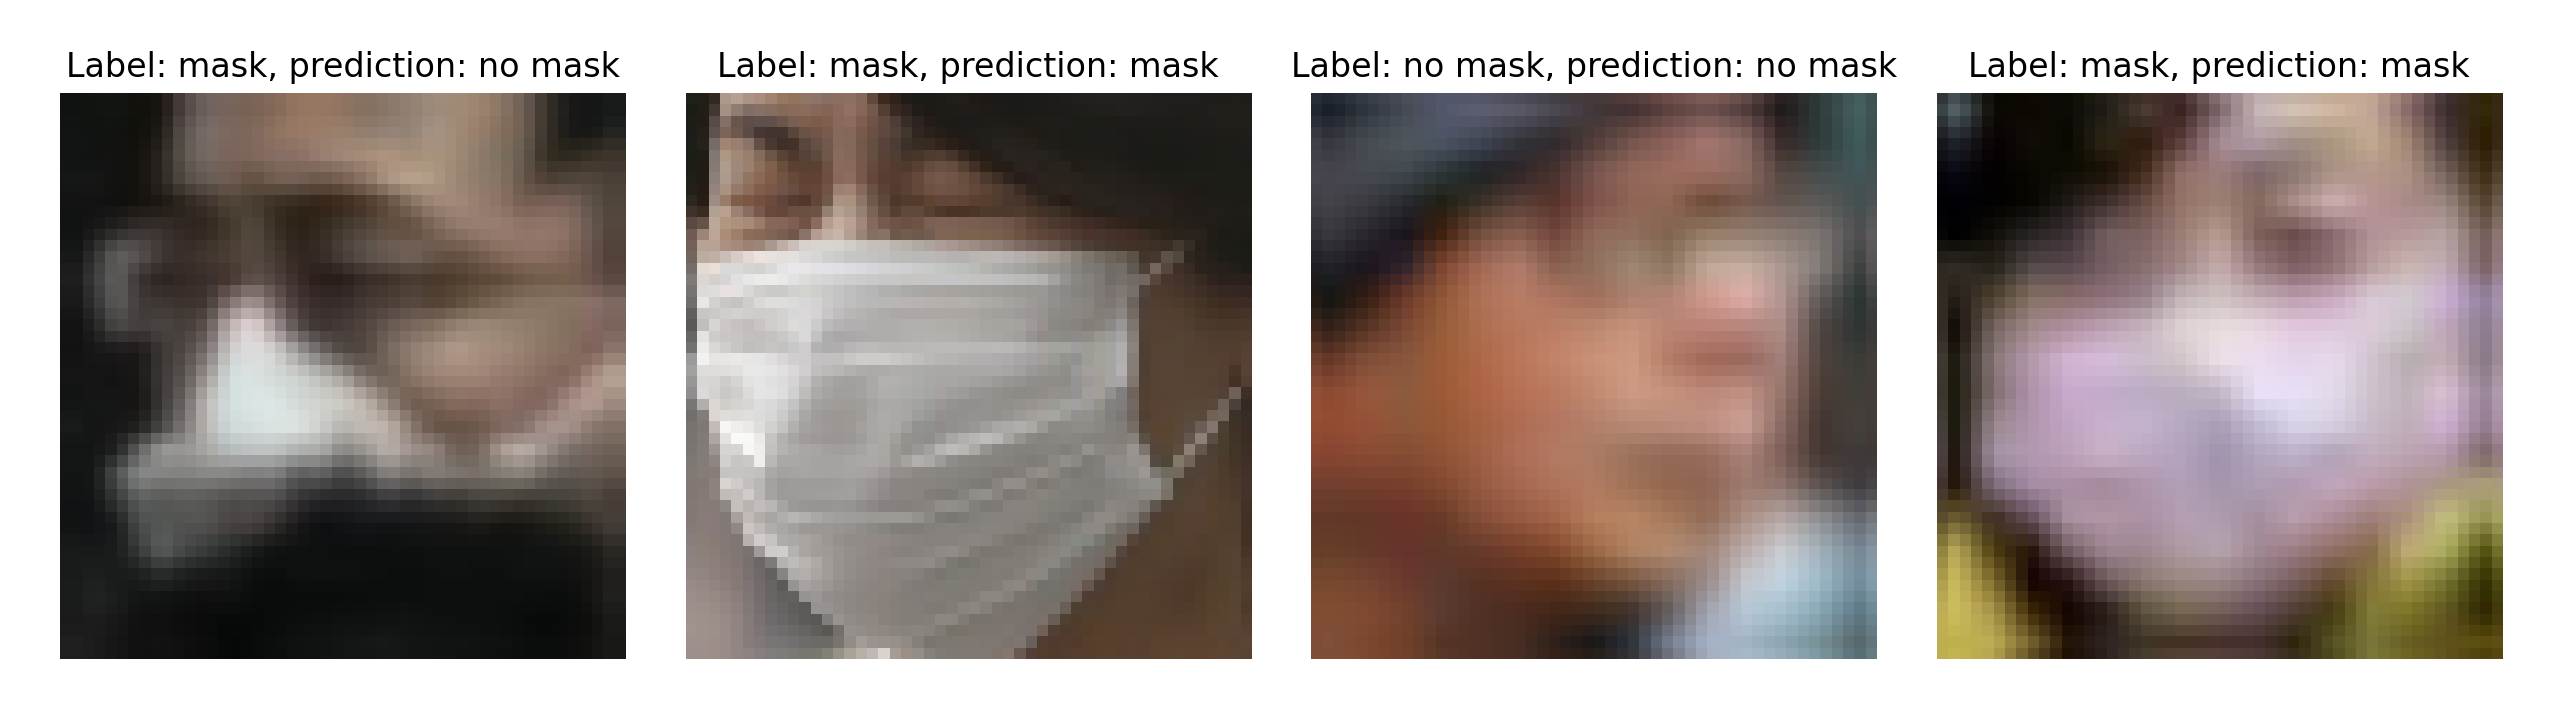

### Test: SIFT+SVM model

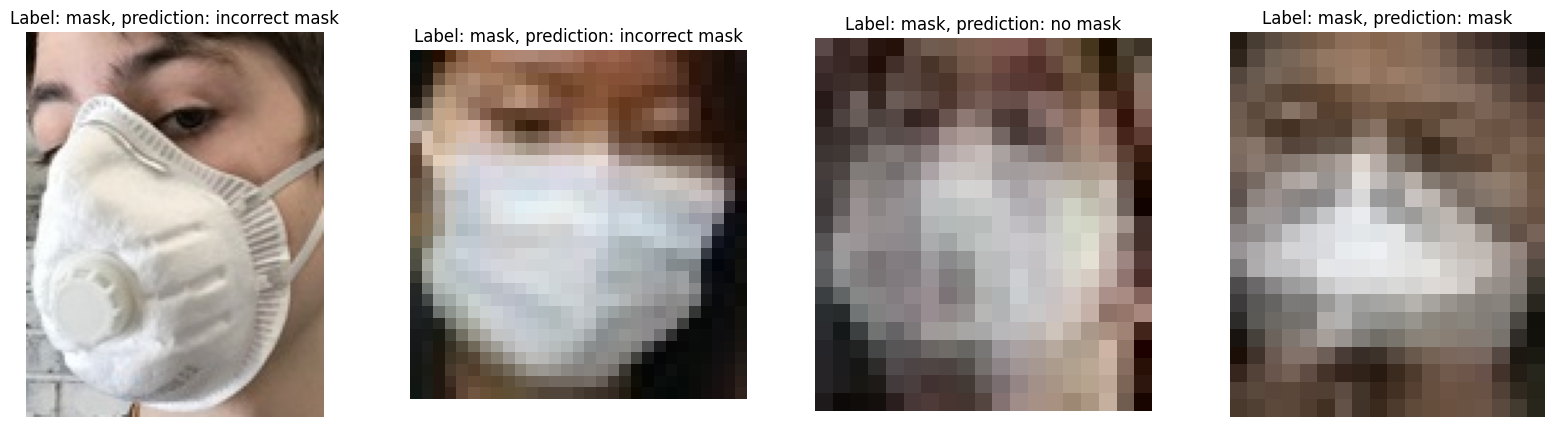

In [ ]:
MaskDetection(path_to_testset, 'siftsvm')

### Test: HOG+SVM model

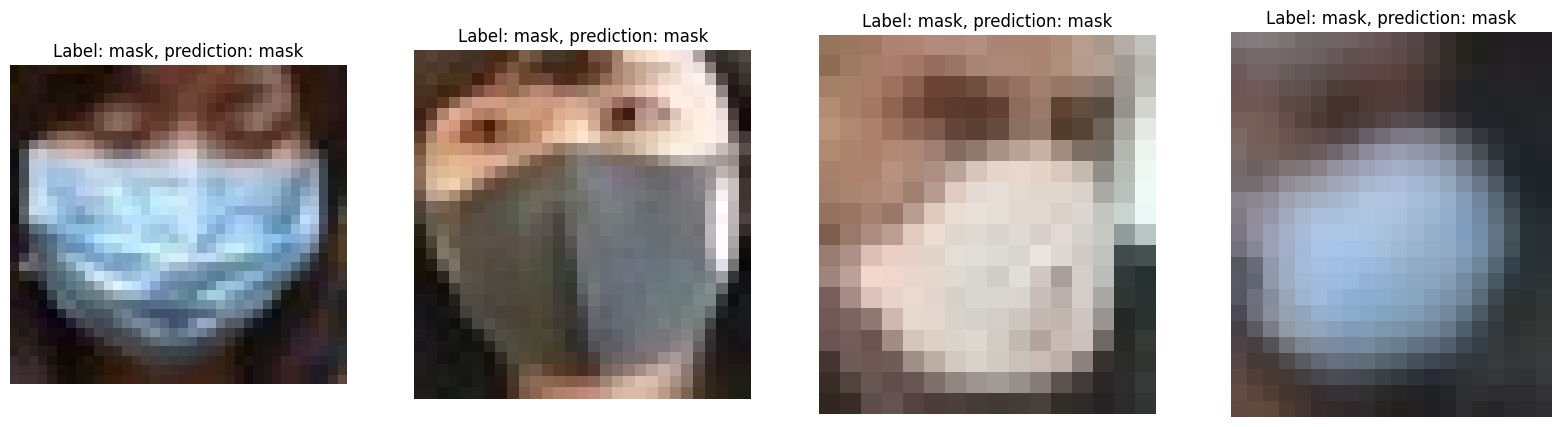

In [ ]:
MaskDetection(path_to_testset, 'hogsvm')

### Test: HOG+MLP model

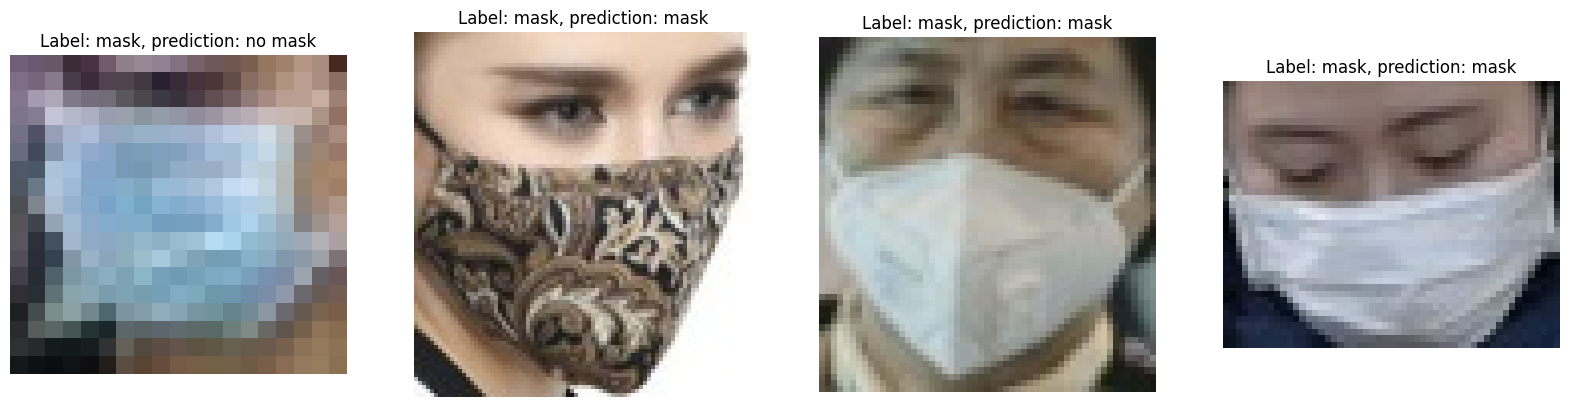

In [ ]:
MaskDetection(path_to_testset, 'hogmlp')

### Test: Pre-trained ResNet34 model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


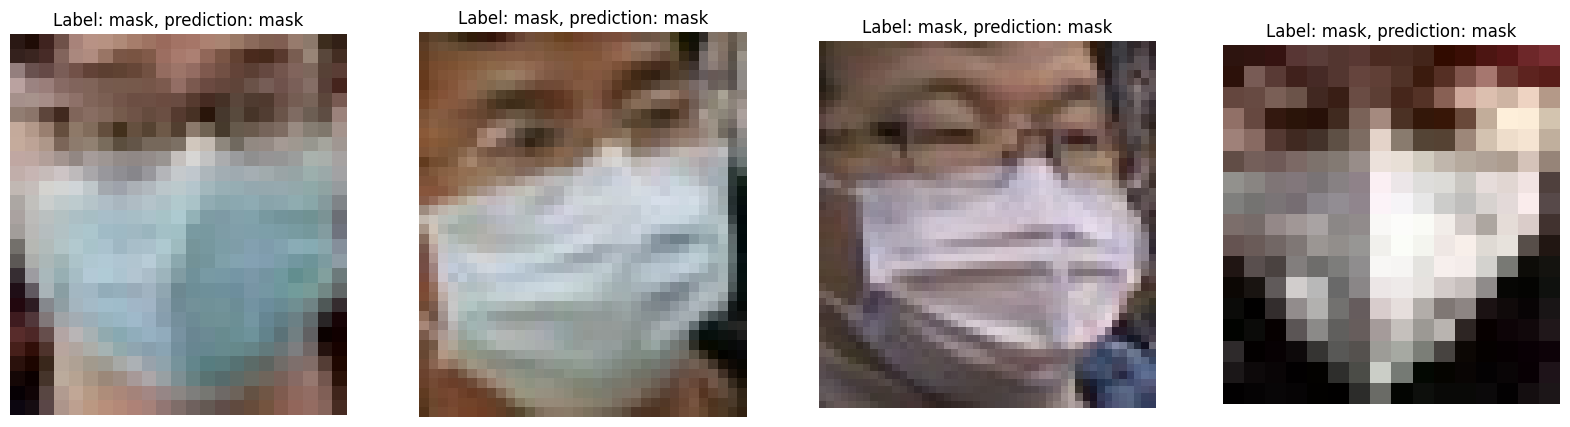

In [ ]:
MaskDetection(path_to_testset, 'resnet')

# Test MaskDetectionVideo

This section should allow a quick test of the `MaskDetectionVideo` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetectionVideo` work.

### Video path

In [ ]:
drive_path = '/content/drive/MyDrive/CW_Folder_PG/Video'
video_path = os.path.join('drive', 'My Drive', drive_path)

# Check any file through the path
print(os.listdir(video_path))

['How To Wear Face Mask The Right Way.mp4']


### Check the size of the video

video shape = (2622, 720, 1280, 3)


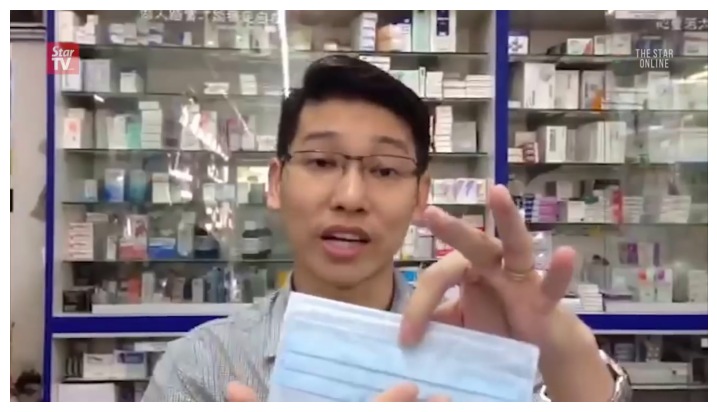

In [ ]:
# This code is derived from lab tutorial 9
%matplotlib inline

cap = cv2.VideoCapture(os.path.join(video_path, 'How To Wear Face Mask The Right Way.mp4'))
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

video = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while fc < frameCount and ret:
    ret, video[fc] = cap.read()
    video[fc] = cv2.cvtColor(video[fc], cv2.COLOR_BGR2RGB)
    fc += 1

cap.release()

print('video shape =', video.shape)

# Show the 10th frame
plt.figure(figsize=(9, 6))
plt.imshow(video[9, :, :, :])
plt.axis('off')
plt.show()

### Define the MaskDetectionVideo function

In [ ]:
# Set the runtime as animation with HTML based backend
rc('animation', html='jshtml')

# Define a function to detect a face for bounding boxes
def detect_faces(frame):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # Use the cascade classifier
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(300, 300))
    return faces

# Define a function for face image preprocessing
def preprocess(face):
    face = cv2.resize(face, (224, 224))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    face_tensor = transform(face).unsqueeze(0) # Add an extra dimension to the tensor
    return face_tensor

# Define a function to predict the face
def predict_mask(face, model):
    output = model(face)
    _, predicted = torch.max(output, 1)
    return predicted.item()

# Define the function MaskDetectionVideo
def MaskDetectionVideo(video_path):
    model = models.resnet34(pretrained=False)
    num_classes = 3
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    saved_model_path = '/content/drive/MyDrive/CW_Folder_PG/Models/pretrained_resnet32_model.pth'
    state_dict = torch.load(saved_model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()

    cap = cv2.VideoCapture(os.path.join(video_path, 'How To Wear Face Mask The Right Way.mp4'))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video = []

    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        if i % 10 == 0:  # Set 10 frames
            faces = detect_faces(frame)

            for (x, y, w, h) in faces: # Set a position of the bounding box around the face
                face = frame[y:y+h, x:x+w] # Extract the region of interest (ROI)
                face_tensor = preprocess(face)
                prediction = predict_mask(face_tensor, model) # Mask detection

                if prediction == 1:
                    color = (0, 255, 0)  # Green for mask
                elif prediction == 2:
                    color = (255, 0, 0)  # Red for incorrect mask
                else:
                    color = (0, 0, 255)  # Blue for no mask
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2) # Define the bounding box spec
                text = "mask" if prediction == 1 else "incorrect mask" if prediction == 2 else "no mask"
                cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3) # Define the text for the bounding box

            video.append(frame)

    cap.release() # Function released

    fig, ax = plt.subplots(figsize=(5, 3)) # For computational efficiency, set the small size of the figure

    def frame(i):
        ax.clear()
        ax.axis('off')
        fig.tight_layout()
        plot = ax.imshow(video[i][:, :, ::-1])  # Convert BGR to RGB
        return plot

    anim = animation.FuncAnimation(fig, frame, frames=range(len(video)))
    plt.close()
    return anim

In [ ]:
# Syntax for the next function is the following:
#
# MaskDetectionVideo(file)

# cascade_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# mask_model = load_mask_detection_model()  # Load your trained mask detection model
# video_path = 'test_video.mp4'
# MaskDetectionVideo(cascade_classifier, mask_model, video_path)

#MaskDetectionVideo('video_final_h264.mp4')

### Test: MaskDetectionVideo

In [ ]:
# MaskDetectionVideo function
MaskDetectionVideo(video_path)

Output hidden; open in https://colab.research.google.com to view.